# Scraping de data.administratif

L'objectif de ce notebook est d'importer toutes les décisions des :

- TA : tribunaux administratifs
- CAA : Cours administratives d'appel

Les données sont disponibles [ici](https://opendata.justice-administrative.fr/) en *open data*.

Ici, on s'attache simplement à télécharger et filtrer grossièrement les fichiers, le gros du travail de cleaning sera fait dans un autre notebook.

Les données téléchargées brutes sont disponibles [ici](../data/raw/) et un fichier csv qui recense tous les fichiers correspondants [là](../data/raw_data.csv).

## 0. Installation et import des librairies

In [12]:
# installation des librairies avec pip (matplotlib et pandas)
! pip install -q matplotlib pandas#

You should consider upgrading via the '/Users/basiledesjuzeur/Documents/legal_analysis/venv_legal/bin/python3 -m pip install --upgrade pip' command.


In [1]:
# import des librairies
import pandas as pd
import requests
import os
import zipfile
import matplotlib.pyplot as plt

## 1. Téléchargement des fichiers

D'abord, on récupère la liste des url à télécharger.

NB : Certains fichiers sont corrompus et ne peuvent pas être téléchargés avec notre méthode. Nous les enlevons donc de la liste, et ils seront ultérieurement rajoutés "à la main".

In [21]:
# liste des fichiers de la CAA (disponible sur le site de l'opendata de la justice administrative)
file_list_CAA = [
    "CAA_202203.zip",
    "CAA_202204.zip",
    "CAA_202205.zip",
    "CAA_202206.zip",
    "CAA_202207.zip",
    "CAA_202208.zip",
    "CAA_202209.zip",
    "CAA_202210.zip",
    "CAA_202211.zip",
    "CAA_202212.zip",
    # "CAA_202301.zip", (fichier corrompu)
    "CAA_202302.zip",
    "CAA_202303.zip",
    "CAA_202304.zip",
    "CAA_202305.zip",
    "CAA_202306.zip",
    "CAA_202307.zip",
    # "CAA_202308.zip", (fichier corrompu)
    "CAA_202309.zip",
    "CAA_202310.zip",
    "CAA_202311.zip",
    "CAA_202312.zip",
    "CAA_202401.zip",
    "CAA_202402.zip",
]

# liste des fichiers de la TA (disponible sur le site de l'opendata de la justice administrative)
file_list_TA = [
    "TA_202206.zip",
    "TA_202207.zip",
    "TA_202208.zip",
    "TA_202209.zip",
    "TA_202210.zip",
    "TA_202211.zip",
    "TA_202212.zip",
    "TA_202301.zip",
    "TA_202302.zip",
    "TA_202303.zip",
    "TA_202304.zip",
    "TA_202305.zip",
    "TA_202306.zip",
    "TA_202307.zip",
    "TA_202308.zip",
    "TA_202309.zip",
    "TA_202310.zip",
    "TA_202311.zip",
    "TA_202312.zip",
    "TA_202401.zip",
    "TA_202402.zip",
]

# base de l'url sur lequel on va construire les urls pour télécharger les fichiers
url_base = "https://opendata.justice-administrative.fr/"

# fonction pour construire l'url de téléchargement d'un fichier
# renvoie l'url et des informations sur le fichier (instance, année, mois)
def construct_url(url_base, file, instance):
    year = file.split("_")[1].split(".")[0][0:4]
    month = file.split("_")[1].split(".")[0][4:6]

    url = url_base + instance + "/" + year + "/" + month + "/" + file
    return url, instance, year, month

# test 
construct_url(url_base, file_list_CAA[0], "DCA")

('https://opendata.justice-administrative.fr/DCA/2022/03/CAA_202203.zip',
 'DCA',
 '2022',
 '03')

Ensuite, on essaie de télécharger un seul fichier pour vérifier que notre *fonction fonctionne*.

In [22]:

# fonction pour télécharger un fichier
def download_file(url, instance, year, month):

    # récupération du dossier contenu à cette url
    # ex : https://opendata.justice-administrative.fr/CAA/2022/03/CAA_202203.zip
    r = requests.get(url)

    # création du chemin pour sauvegarder le fichier
    # ex : ../data/raw/DCA/2022/03
    path = os.path.join("../data/raw", instance, year, month)

    # création du dossier pour contenir le fichier, s'il n'existe pas
    if not os.path.exists(path):
        os.makedirs(path)

    # sauvegarde du fichier
    # ex : ../data/raw/DCA/2022/03/CAA_202203.zip
    with open(os.path.join(path, url.split("/")[-1]), "wb") as f:
        f.write(r.content)

    # décompression du fichier
    # ex : ../data/raw/DCA/2022/03/CAA_202203.zip -> ../data/raw/DCA/2022/03/CAA_202203
    with zipfile.ZipFile(os.path.join(path, url.split("/")[-1]), "r") as zip_ref:
        zip_ref.extractall(path)

    # suppression du fichier zip
    os.remove(os.path.join(path, url.split("/")[-1]))

# test
url, instance, year, month = construct_url(url_base, file_list_CAA[0], "DCA")
download_file(url, instance, year, month)

Au vu du bon fonctionnement de notre méthode, on peut maintenant télécharger toutes les données.

In [23]:
# télécharger tous les fichiers des tribunaux administratifs
for file in file_list_TA:
    url, instance, year, month = construct_url(url_base, file, "DTA")
    download_file(url, instance, year, month)

# télécharger tous les fichiers des cours administratives d'appel
for file in file_list_CAA:
    url, instance, year, month = construct_url(url_base, file, "DCA")
    download_file(url, instance, year, month)

Pour finir, on rajoute les fichiers corrompus à notre base de données.(*DCA 202301 et DCA 202308*).

In [26]:
# on crée les dossiers corrompus dans notre arborescence
os.makedirs("../data/raw/DCA/2023/01")
os.makedirs("../data/raw/DCA/2023/08")

# on déplace les fichiers corrompus dans les dossiers correspondants
! mv ../../../Downloads/DCA_2023_01/*.xml ../data/raw/DCA/2023/01
! mv ../../../Downloads/DCA_2023_08/*.xml ../data/raw/DCA/2023/08

## 2. Première sélection des fichiers d'intérêts.

Nous venons de télécharger toutes les données de l'open data concernant les TA et les CAA.

Cependant, seulement une petite partie de ces informations nous intéresse, on va donc procéder à un premier filtre pour éliminer celles dont nous n'avons pas besoin.

Pour pouvoir effectuer ce filtre, nous allons utiliser une *dataframe* pandas (un tableau), sauvegardée dans [ce fichier](../data/raw_data.csv), qui nous servira de registre. 

In [31]:
# liste qui va contenir les chemins de tous les fichiers xml
# ex : ../data/raw/DCA/2022/03/CAA_202203/CAA_202203_0001.xml
paths = []

# parcourir l'arborescence pour récupérer les chemins des fichiers xml
for root, dirs, files in os.walk("../data/raw"):
    # pour tous les fichiers
    for file in files:
        # si le fichier est un fichier xml
        if file.endswith(".xml"):

            # on fait en sorte que le chemin soit indépendant du système d'exploitation
            # i.e. on remplace les \ par des /
            path = os.path.join(root, file).replace("\\", "/")
            # on ajoute le chemin du fichier à la liste

            paths.append(path)

# on crée un dataframe avec les chemins des fichiers
df = pd.DataFrame(paths, columns=["path"])

# que l'on sauvegarde dans un fichier csv
df.to_csv("../data/raw_data.csv", index=False)

In [32]:
# informations sur le dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295037 entries, 0 to 295036
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    295037 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


On a donc 300 000 décisions de justices à catégoriser.

### 2.1 Note sur l'organisation des fichiers

Les dossiers ne sont pas construits de la même manière :

- DCA :
    - année
        - mois 
            - décision

- DTA :
    - année 
        - mois 
            - département du tribunal
                - décision

Pour faciliter la lecture, on va harmoniser les structures en calquant celle de la DTA sur celle de la DCA.


In [35]:
# fonction qui renvoie le nouveau chemin d'un fichier DTA
# ex : ../data/raw/DTA/2022/03/TA_202203/69/TA_202203_0001.xml 
# -> ../data/process/DTA/2022/03/TA_202203/TA_202203_0001.xml
def new_path_DTA(path):
    # si le chemin contient "DTA"
    if "DTA" in path:
        # extraire l'année et le mois du chemin
        year = path.split("/")[4]
        month = path.split("/")[5]

        # construire le nouveau chemin
        new_path = (
            "../data/process/DTA/" + year + "/" + month + "/" + path.split("/")[-1]
        )

        return new_path
    
    # sinon, on renvoie le chemin tel quel
    else:
        return path


# on applique la fonction à la colonne "path" du dataframe
df["new_path"] = df["path"].apply(new_path_DTA)

### 2.2 Contextualisation des données que l'on cherche

Les deux instances émettent plusieurs types de documents :

- Tribunaux administratifs :
    - DTA : Décision des tribunaux administratifs
    - ORTA : Ordonnance de renvoi des tribunaux administratifs

- Cours administratives d'appel :
    - DCA : Décision des cours administratives
    - ORCA : Ordonnance de renvoi des cours administratives

Les ordonnances de renvoi s'insèrent dans le mécanisme suivant :

1. Le contribuable édite ses comptes
2. L'administration fiscale envoie une proposition de rectification
3. L'entreprise envoie une contre-proposition 
4. L'administation fiscale statue sur cette contre-proposition et décide d'une pénalité

Le contribuable peut alors décider de demander un recours.

5. Le tribunal administratif (TA) évalue ce recours 
    - le TA prend une décision -> **DTA**
    ou 
    - le TA renvoie la décision à la CAA -> **ORTA**

6. En cas d'ORTA
    - la CAA prend une décision -> **DCA**
    ou
    - la CAA renvoie la décision au Conseil d'Etat -> **ORTA**

Le Conseil d'Etat évalue ensuite si la décision de la CAA a été bien prise.

**Ceci étant dit**, les ordonnances de renvoi ne nous intéressent pas particulièrement ici.

In [36]:
# fonction qui regarde si un fichier est une ordonnance de renvoi
def ordonnance_de_renvoi(path):

    # nom du fichier
    # ex : ../data/raw/DCA/2022/03/CAA_202203/CAA_202203_0001.xml -> CAA_202203_0001.xml
    file_name = path.split("/")[-1]

    # si le nom du fichier contient "ORTA" ou "ORCA"
    if "ORTA" in file_name or "ORCA" in file_name:

        # on renvoie True
        return True

    # sinon
    else:
        # on renvoie False
        return False


# on applique la fonction à la colonne path du dataframe
df["ordonnance_de_renvoi"] = df["path"].apply(ordonnance_de_renvoi)

In [37]:
# fonction qui catégorise les fichiers en fonction de leur instance
def instance(path):

    # extraire le nom du dossier parent du fichier
    # ex : ../data/raw/DCA/2022/03/CAA_202203/CAA_202203_0001.xml -> DCA
    folder = path.split("/")[3]

    # si le dossier parent est "DCA"
    if folder == "DCA":
        return "CAA"
    
    # si le dossier parent est "DTA"
    if folder == "DTA":
        return "TA"
    else:
        return "None"


# on applique la fonction à la colonne path du dataframe
df["instance"] = df["new_path"].apply(instance)

### 2.3 Un premier graphique : Est ce qu'il y a beaucoup d'ordonnances de renvoi ?

Sans surprise et par construction :
- Il y a plus de décisions dans les TA que les CAA

Il est intéressant de noter qu'une part importante des décisions sont renvoyées.

NB : On a mis les chiffres pour pouvoir refaire proprement les graphiques sur pptx ou excel

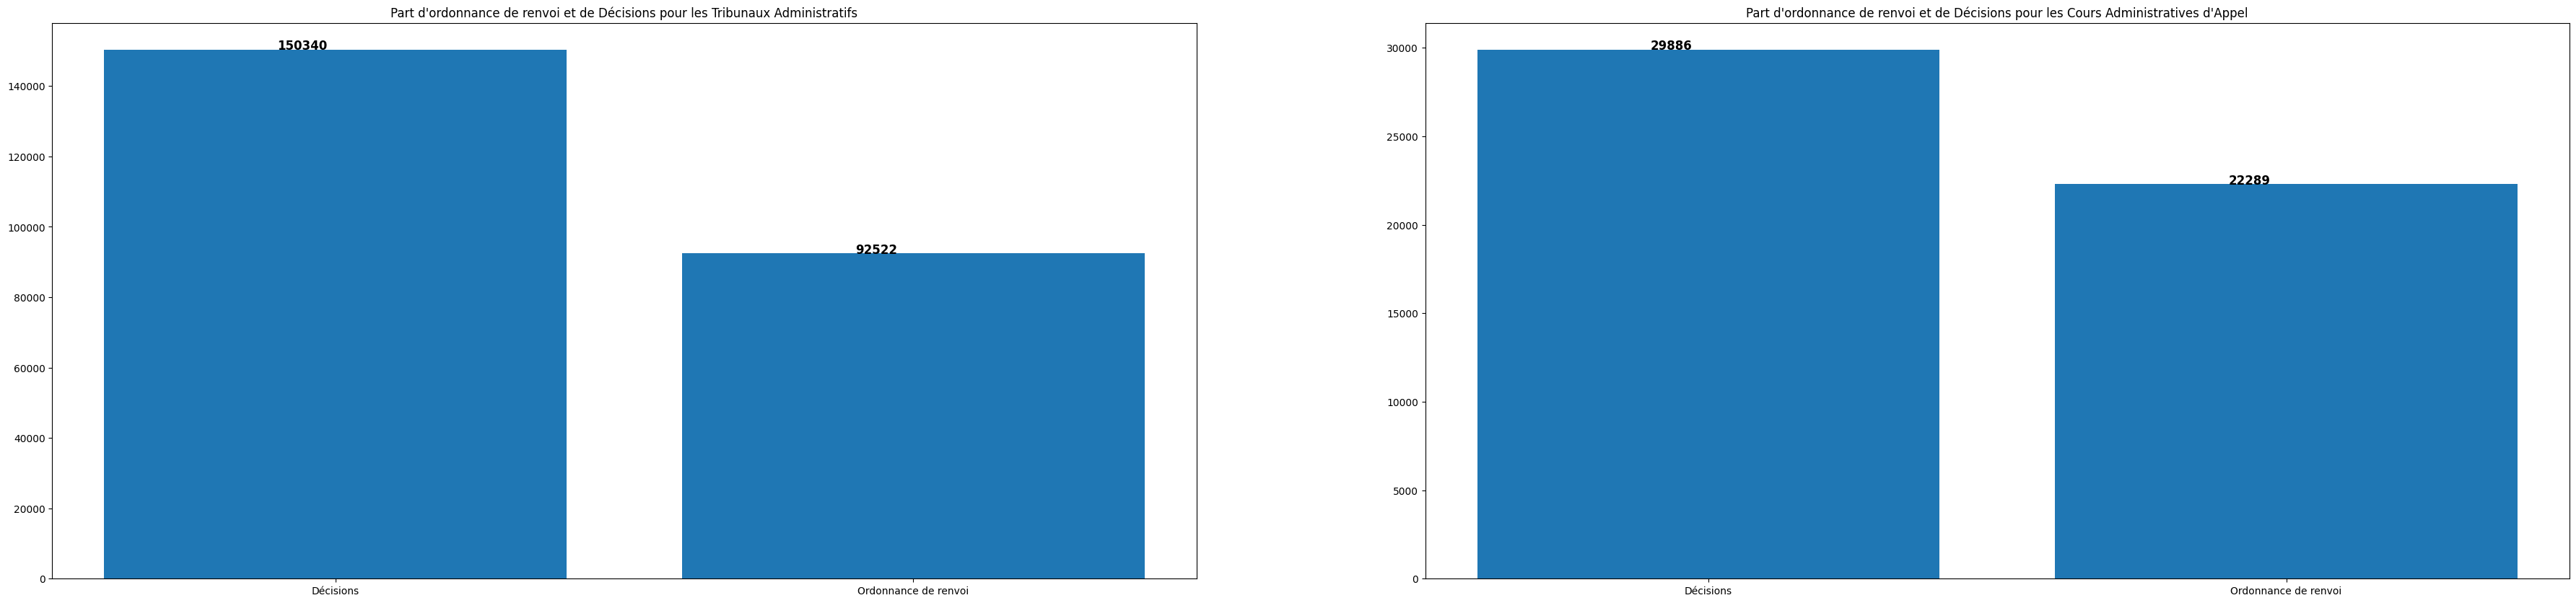

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(45, 10))

# number of ordonnance de renvoi for TA
or_ta = df[df["instance"] == "TA"]["ordonnance_de_renvoi"].value_counts()
x_label = ["Décisions", "Ordonnance de renvoi"]
axs[0].bar(x_label, or_ta)
axs[0].set_title(
    "Part d'ordonnance de renvoi et de Décisions pour les Tribunaux Administratifs"
)
# set the numbers in the top of the bars
for i, v in enumerate(or_ta):
    axs[0].text(i - 0.1, v + 0.1, str(v), fontsize=12, fontweight="bold")


# number of ordonnance de renvoi for CAA
or_caa = df[df["instance"] == "CAA"]["ordonnance_de_renvoi"].value_counts()
axs[1].bar(x_label, or_caa)
axs[1].set_title(
    "Part d'ordonnance de renvoi et de Décisions pour les Cours Administratives d'Appel"
)
# set the numbers on the top of the bars
for i, v in enumerate(or_caa):
    axs[1].text(i - 0.1, v + 0.1, str(v), fontsize=12, fontweight="bold")


# save the figure
plt.savefig("../output/part_ordonnance_de_renvoi.png")

## 3. Extraction des données importantes

Pour chaque fichier, on extraie à partir du chemin du fichier:

- l'année 
- le mois
- l'identifiant de la décision



In [39]:
# fonction qui renvoie l'année où a été rendue une décision
def get_year(path):
    return path.split("/")[4]

# fonction qui renvoie le mois où a été rendue une décision
def get_month(path):
    return path.split("/")[5]

# fonction qui renvoie l'id d'une décision
def get_id(path):
    file_name = path.split("/")[-1]
    id = file_name.split("_")[1]
    return id

# chemin test pour les fonctions
# devrait renvoyer 
# année : 2022
# mois : 11
# id : 2003387
test = "./data/raw/DTA/2022/11/DTA_2003387_20221117.xml"


print(get_year(test))
print(get_month(test))
print(get_id(test))

2022
11
2003387


In [40]:
# application de ces fonctions au dataframe
df["year"] = df["path"].apply(get_year)
df["month"] = df["path"].apply(get_month)
df["id"] = df["path"].apply(get_id)

## 4. Edition du csv de sauvegarde

Pour finir ce notebook et garder nos analyses, on enregistre l'état actuel de notre dataframe dans un csv ["intermediate_data"](../data/intermediate_data.csv).

In [41]:
df.to_csv("../data/intermediate_data.csv", index=False)